In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for pipelines and grid search
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

# Dimensionality Reduction algoriths
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import RFE
from sklearn.manifold import LocallyLinearEmbedding

# Regression algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics for evaluating classification models
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support, precision_recall_curve

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Performance metrics for model evaluation
from sklearn import metrics

# SHAP explainability library
import shap

import datetime

import warnings
warnings.filterwarnings("ignore")

### 1. EDA

In [93]:
# Import the raw data from clinical and cnrq/miRNA samples data files

df_clinical = pd.read_csv("ICORG database for analysis 2021 - clinical - CSV.csv")

df_cnrq = pd.read_csv("ICORG database for analysis 2021 - cnrq - CSV.csv")

df_cnrq.drop('Unnamed: 17', axis=1, inplace=True)

In [94]:
# Take a look at the the two data frames

df_clinical.head()

Patient No.   Age ER Status PR Status HER2 Status Tumour Subtype  \
0          1.0  67.0  Positive  Negative    Negative      Luminal A   
1          2.0  53.0  Positive  Positive    Negative      Luminal A   
2          3.0  65.0  Positive  Positive    Negative      Luminal A   
3          4.0   NaN  Positive  Negative    Positive      Luminal B   
4          5.0   NaN  Positive  Positive    Positive      Luminal B   

  Node Result  Mammogram Size  Tumour Grade Surgical Procedure  \
0    Negative             NaN           2.0                WLE   
1         NaN             4.0           2.0                WLE   
2    Positive             7.0           2.0                WLE   
3    Positive             7.0           2.0         Mastectomy   
4    Negative             NaN           2.0         Mastectomy   

   Invasive Tumour size on histology (cm) Tumour bed response to NACT  \
0                                     3.0                     Partial   
1                                     6.3                     Partial   
2                                     4.0                     Partial   
3                                     3.8                        Good   
4                                     1.4                        Good   

   Number of Nodes Involved Final combined pCR status   NPI  Mammographic NPI  
0                       5.0                        No  5.60               NaN  
1                       3.0                        No  6.26               4.8  
2                      13.0                        No  5.60               6.4  
3                       4.0                        No  5.76               6.4  
4                       0.0                        No  3.28               NaN

In [95]:
df_cnrq.head()

Samples Let-7a CNRQ Let-7a SE(CNRQ) miR-10b CNRQ miR-10b SE(CNRQ)  \
0     1-1    0.619542        0.043492    -0.258232         0.022169   
1     1-2    0.268956        0.031020     0.466741         0.037892   
2     1-3   -0.330399        0.038581    -0.271332         0.038458   
3     1-4    1.202915        0.019768     1.314104         0.016260   
4     1-5    0.668195        0.029424     0.473851         0.031627   

  miR-145 CNRQ miR-145 SE(CNRQ) miR-155 CNRQ miR-155 SE(CNRQ) miR-16 CNRQ  \
0     0.248945         0.032727    -1.948633         0.038655    0.245929   
1     0.688605         0.029129          NaN              NaN    0.249567   
2     0.354952         0.031385     0.057162         0.040371   -0.265812   
3     1.859136         0.038551     1.561874         0.019562    1.117200   
4     0.841119         0.025823    -3.370786         0.045068    0.241619   

  miR-16 SE(CNRQ) miR-195 CNRQ miR-195 SE(CNRQ) miR-21 CNRQ miR-21 SE(CNRQ)  \
0        0.010475     0.756180         0.012659    0.588606        0.013795   
1        0.014383     0.528927         0.020011    0.631142        0.028848   
2        0.021709    -0.283067         0.029393   -0.297470        0.036457   
3        0.010158    -0.496248         0.030897    1.799202        0.025332   
4        0.035241     0.713116         0.020807    0.788514        0.039980   

  miR-425 CNRQ miR-425 SE(CNRQ)  
0    -0.245929         0.014497  
1    -0.249567         0.020417  
2     0.265812         0.027783  
3    -1.117200         0.019028  
4    -0.241619         0.024060

In [96]:
# Create two new features by splitting the "Sample" feature into "Patient No." and "Sample No."
df_cnrq.insert(0,'Patient No.',df_cnrq.Samples.str.split('-').str[0])
df_cnrq.insert(1,'Sample No.',df_cnrq.Samples.str.split('-').str[1])
df_cnrq.drop('Samples', axis=1, inplace=True)

idxs = list(df_cnrq.columns)[0:2]
cols = list(df_cnrq.columns)[2:]

df_cnrq[idxs] = df_cnrq[idxs].apply(pd.to_numeric, errors='coerce', axis=1)
df_cnrq[cols] = df_cnrq[cols].apply(pd.to_numeric, errors='coerce', axis=1)

df_clinical['Patient No.'] = df_clinical['Patient No.'].apply(pd.to_numeric, errors='coerce')

In [97]:
# Each patient has up to 5 sample rows for each miRNA measurement so we need to denormalise before joining

f_cnrq_denorm = pd.DataFrame()

# Denormalisation routine

for x in range(1, 6):
    temp_df = df_cnrq[(df_cnrq['Sample No.'] == x)].copy()
    
    cols = temp_df.columns[2:]
    
    for col in cols:
        new_col = "Sample_" + str(x) + "_" + col
        temp_df.rename(columns = {col:new_col}, inplace = True)

    temp_df.drop('Sample No.', axis=1, inplace=True)
    temp_df.set_index('Patient No.')
    
    if x > 1:
        df_cnrq_denorm = pd.merge(df_cnrq_denorm, temp_df, how='left', on='Patient No.')

    else:
        df_cnrq_denorm = temp_df.copy()   

# Join datasets
df = pd.merge(df_clinical, df_cnrq_denorm, on='Patient No.', how='left')

In [98]:
# Drop rows with all columns data missing values

df = df.dropna(how='all')

In [99]:
# Based on discussion with James, columns with'_miR_10' can be deleted as well as all of Sample 5

del_col_names = ['Sample_1_miR-10b CNRQ', 'Sample_1_miR-10b SE(CNRQ)',
                 'Sample_2_miR-10b CNRQ', 'Sample_2_miR-10b SE(CNRQ)',
                 'Sample_3_miR-10b CNRQ', 'Sample_3_miR-10b SE(CNRQ)',
                 'Sample_4_miR-10b CNRQ', 'Sample_4_miR-10b SE(CNRQ)',
                 'Sample_5_miR-10b CNRQ', 'Sample_5_miR-10b SE(CNRQ)'
                ]
df = df.drop(del_col_names, axis=1)

# Drop columns from Sample 5

df = df.drop(df.filter(regex='Sample_5').columns, axis=1)

df = df.drop(df.filter(regex='Unnamed').columns, axis=1)

In [100]:
# Reset all 'missing' values with standard NaN

df = df.replace('Missing', np.NaN)

In [101]:
# Drop Mammographic NPI, for now, as it has a large amount of missing data
# Drop NPI as this is a calculated value from Invasive Tumour Size, Number of Nodes and Tumour Grade
# Patient No. is not needed for this part of the analysis

drop_cols = ['Mammographic NPI', 'Patient No.', 'NPI'
            , 'Tumour bed response to NACT'
            , 'Invasive Tumour size on histology (cm)'
            ]

df = df.drop(drop_cols, axis=1)

In [102]:
df.shape

(124, 67)

In [103]:
# Summary statistics on numeric data

df.describe()

Age  Mammogram Size  Tumour Grade  Number of Nodes Involved  \
count  102.000000       89.000000    122.000000                120.000000   
mean    55.088235        4.173034      2.459016                  2.916667   
std     10.599928        2.065670      0.516625                  5.389974   
min     25.000000        0.800000      1.000000                  0.000000   
25%     48.000000        2.800000      2.000000                  0.000000   
50%     55.000000        3.700000      2.000000                  0.000000   
75%     63.000000        5.000000      3.000000                  3.250000   
max     76.000000       10.000000      3.000000                 26.000000   

       Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
count            112.000000                112.000000             111.000000   
mean              -0.079412                  0.026967               0.008271   
std                0.732854                  0.012864               0.578259   
min               -3.099901                  0.008775              -2.286769   
25%               -0.465806                  0.017465              -0.336913   
50%                0.007653                  0.024258               0.142475   
75%                0.349460                  0.035144               0.386108   
max                1.606284                  0.101109               1.287875   

       Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
count                 111.000000             113.000000   
mean                    0.028359              -0.154860   
std                     0.014445               0.835144   
min                     0.003589              -4.049647   
25%                     0.017690              -0.339528   
50%                     0.026165               0.000212   
75%                     0.035616               0.228773   
max                     0.103618               2.219914   

       Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count                 113.000000            116.000000   
mean                    0.027256              0.006177   
std                     0.013255              0.292226   
min                     0.004295             -0.722485   
25%                     0.018420             -0.164788   
50%                     0.026023             -0.008289   
75%                     0.034086              0.191508   
max                     0.102839              0.731800   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                116.000000             113.000000   
mean                   0.021113              -0.045760   
std                    0.013447               0.583540   
min                    0.001627              -2.272715   
25%                    0.012525              -0.290821   
50%                    0.018521               0.079972   
75%                    0.025076               0.357126   
max                    0.103076               1.026940   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                 113.000000            113.000000   
mean                    0.024106             -0.175079   
std                     0.012219              0.795284   
min                     0.008899             -4.472507   
25%                     0.016539             -0.347641   
50%                     0.021701             -0.100311   
75%                     0.029127              0.269272   
max                     0.102075              1.049880   

       Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
count                113.000000             116.000000   
mean                   0.028370              -0.006177   
std                    0.013954               0.292226   
min                    0.006977              -0.731800   
25%                    0.018756              -0.191508   
50%                    0.025257               0.008289   
75%                    0.035094               0.164788   
max                    0.104047   

In [104]:
# Calculate the percentage of missing data for each feature

pd.set_option("display.max_rows", None, "display.max_columns", None)
df.isna().sum()/df.shape[0]*100

Age                          17.741935
ER Status                     0.000000
PR Status                     0.000000
HER2 Status                   0.000000
Tumour Subtype                0.000000
Node Result                  27.419355
Mammogram Size               28.225806
Tumour Grade                  1.612903
Surgical Procedure            1.612903
Number of Nodes Involved      3.225806
Final combined pCR status     3.225806
Sample_1_Let-7a CNRQ          9.677419
Sample_1_Let-7a SE(CNRQ)      9.677419
Sample_1_miR-145 CNRQ        10.483871
Sample_1_miR-145 SE(CNRQ)    10.483871
Sample_1_miR-155 CNRQ         8.870968
Sample_1_miR-155 SE(CNRQ)     8.870968
Sample_1_miR-16 CNRQ          6.451613
Sample_1_miR-16 SE(CNRQ)      6.451613
Sample_1_miR-195 CNRQ         8.870968
Sample_1_miR-195 SE(CNRQ)     8.870968
Sample_1_miR-21 CNRQ          8.870968
Sample_1_miR-21 SE(CNRQ)      8.870968
Sample_1_miR-425 CNRQ         6.451613
Sample_1_miR-425 SE(CNRQ)     6.451613
Sample_2_Let-7a CNRQ     

In [105]:
# Calculate skewness of distribution

from scipy.stats import skew

skew_df = pd.DataFrame(columns=['Feature', 'Skewness'])

cols = df.select_dtypes(include='number').columns

for col in cols:
    skew_val = np.round(skew(df[col], nan_policy='omit'), 4)
    new_row = {'Feature': col, 'Skewness': skew_val}
    skew_df = skew_df.append(new_row, ignore_index=True)

skew_df

Feature  Skewness
0                         Age   -0.1131
1              Mammogram Size    0.7988
2                Tumour Grade   -0.0163
3    Number of Nodes Involved    2.4523
4        Sample_1_Let-7a CNRQ   -0.8908
5    Sample_1_Let-7a SE(CNRQ)    1.9288
6       Sample_1_miR-145 CNRQ   -0.9191
7   Sample_1_miR-145 SE(CNRQ)    1.5302
8       Sample_1_miR-155 CNRQ   -2.0294
9   Sample_1_miR-155 SE(CNRQ)    1.7716
10       Sample_1_miR-16 CNRQ   -0.0428
11   Sample_1_miR-16 SE(CNRQ)    2.4235
12      Sample_1_miR-195 CNRQ   -1.2906
13  Sample_1_miR-195 SE(CNRQ)    2.6217
14       Sample_1_miR-21 CNRQ   -2.0074
15   Sample_1_miR-21 SE(CNRQ)    1.8817
16      Sample_1_miR-425 CNRQ    0.0428
17  Sample_1_miR-425 SE(CNRQ)    6.9500
18       Sample_2_Let-7a CNRQ   -0.2381
19   Sample_2_Let-7a SE(CNRQ)    0.4741
20      Sample_2_miR-145 CNRQ   -0.3903
21  Sample_2_miR-145 SE(CNRQ)    0.3099
22      Sample_2_miR-155 CNRQ   -0.4426
23  Sample_2_miR-155 SE(CNRQ)    0.3946
24       Sample_2_miR-16 CNRQ   -0.4162
25   Sample_2_miR-16 SE(CNRQ)    1.0687
26      Sample_2_miR-195 CNRQ   -2.1577
27  Sample_2_miR-195 SE(CNRQ)    0.4038
28       Sample_2_miR-21 CNRQ   -1.2060
29   Sample_2_miR-21 SE(CNRQ)    0.9121
30      Sample_2_miR-425 CNRQ    0.4162
31  Sample_2_miR-425 SE(CNRQ)    2.4450
32       Sample_3_Let-7a CNRQ   -0.8865
33   Sample_3_Let-7a SE(CNRQ)    0.6064
34      Sample_3_miR-145 CNRQ    0.3395
35  Sample_3_miR-145 SE(CNRQ)    0.9391
36      Sample_3_miR-155 CNRQ   -1.1272
37  Sample_3_miR-155 SE(CNRQ)    0.3588
38       Sample_3_miR-16 CNRQ   -0.0064
39   Sample_3_miR-16 SE(CNRQ)    0.8069
40      Sample_3_miR-195 CNRQ   -1.3693
41  Sample_3_miR-195 SE(CNRQ)    0.9511
42       Sample_3_miR-21 CNRQ   -0.7334
43   Sample_3_miR-21 SE(CNRQ)    0.9786
44      Sample_3_miR-425 CNRQ    0.0064
45  Sample_3_miR-425 SE(CNRQ)    0.8625
46       Sample_4_Let-7a CNRQ   -0.4240
47   Sample_4_Let-7a SE(CNRQ)    0.6311
48      Sample_4_miR-145 CNRQ    0.3687
49  Sample_4_miR-145 SE(CNRQ)    9.0697
50      Sample_4_miR-155 CNRQ   -0.5581
51  Sample_4_miR-155 SE(CNRQ)    0.7610
52       Sample_4_miR-16 CNRQ    0.0361
53   Sample_4_miR-16 SE(CNRQ)    0.8654
54      Sample_4_miR-195 CNRQ   -1.1400
55  Sample_4_miR-195 SE(CNRQ)    7.4059
56       Sample_4_miR-21 CNRQ   -0.8806
57   Sample_4_miR-21 SE(CNRQ)    0.8742
58      Sample_4_miR-425 CNRQ   -0.0361
59  Sample_4_miR-425 SE(CNRQ)    0.7628

#### Determining Mean or Median imputer for Skewed Data
From: https://www.pluralsight.com/guides/interpreting-data-using-descriptive-statistics-python

- Highly skewed distribution: If the skewness value is less than −1 or greater than +1.

- Moderately skewed distribution: If the skewness value is between −1 and −½ or between +½ and +1.

- Approximately symmetric distribution: If the skewness value is between −½ and +½.

Therefore, for _Skewness_ values between -0.5 and + 0.5 we use *mean* otherwise use *median*.

This is also very useful in determining whether to use MinMaxScaler or StandardScaler.

MinmaxScaler is negatively impacted by large skewness, i.e. outliers, while StandardScaler is not.

We can use StandardScaler followed by MinMax.

In [106]:
# Display the distribution of categorical features to determine class imbalance

all_cols = df.columns

cat_cols = list(set(all_cols) - set(cols))

for cat in cat_cols:
    cnt = df[cat].count()
    num_elem = (df.groupby([cat])[cat].count())/cnt*100
    print (num_elem, '\n')

ER Status
Negative    34.677419
Positive    65.322581
Name: ER Status, dtype: float64 

Tumour Subtype
Her2               12.903226
Luminal A          49.193548
Luminal B          17.741935
Triple Negative    20.161290
Name: Tumour Subtype, dtype: float64 

Final combined pCR status
No     73.333333
Yes    26.666667
Name: Final combined pCR status, dtype: float64 

Node Result
Negative    14.444444
Positive    85.555556
Name: Node Result, dtype: float64 

PR Status
Negative    46.774194
Positive    53.225806
Name: PR Status, dtype: float64 

Surgical Procedure
Mastectomy    44.262295
WLE           55.737705
Name: Surgical Procedure, dtype: float64 

HER2 Status
Negative    69.354839
Positive    30.645161
Name: HER2 Status, dtype: float64 



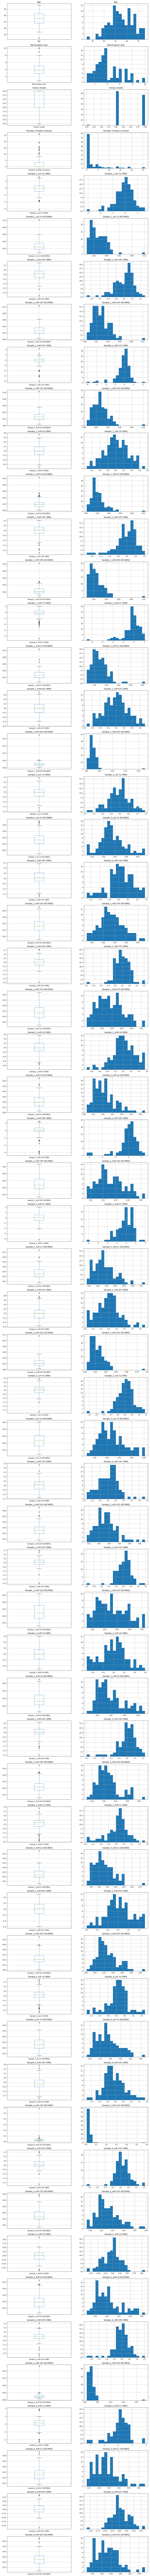

In [107]:
# Plot histograms of number values

fig = plt.figure(figsize=(16,300))
n= 1
num = len(cols)

for col in cols:
    ax1 = fig.add_subplot(num, 2, n)
    ax1.set_title(col)
    df.boxplot(column=col)

    ax2 = fig.add_subplot(num, 2, n+1)
    ax2.set_title(col)
    df[col].hist(bins=20)
    
    n+=2

In [108]:
# Export the df dataset (unprocessed)

df.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_No_Processing.csv")

In [109]:
# Map 'Final combined pCR status' to number values for classification model

final_pcr_status = {'No': 0, 'Yes': 1}

df['Final combined pCR status'] = df['Final combined pCR status'].map(final_pcr_status)

In [110]:
df.shape

(124, 67)

In [111]:
# Drop rows where traget feature is NA.
idx = df[df['Final combined pCR status'].isna()].index
df.drop(idx, inplace=True)

In [112]:
# Separate the dataset into Training and Test Datasets before doing any analysis or feature engineering
# NOTE: Separating the data depends on whether we will be doing regression or classification.
# Classification needs to be stratified on the target so we get even distributions of classes in train and test.

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Final combined pCR status'])
print("Dataset shape: Training", df_train.shape, "Test", df_test.shape)

Dataset shape: Training (96, 67) Test (24, 67)


In [113]:
# Calculate skewness of distribution

from scipy.stats import skew

skew_df = pd.DataFrame(columns=['Feature', 'Skewness'])

cols = df_train.select_dtypes(include='number').columns

for col in cols:
    skew_val = np.round(skew(df_train[col], nan_policy='omit'), 4)
    new_row = {'Feature': col, 'Skewness': skew_val}
    skew_df = skew_df.append(new_row, ignore_index=True)

skew_df

Feature  Skewness
0                         Age   -0.0516
1              Mammogram Size    0.9259
2                Tumour Grade   -0.2028
3    Number of Nodes Involved    2.8112
4   Final combined pCR status    1.0314
5        Sample_1_Let-7a CNRQ   -0.4063
6    Sample_1_Let-7a SE(CNRQ)    0.4025
7       Sample_1_miR-145 CNRQ   -1.1160
8   Sample_1_miR-145 SE(CNRQ)    0.5094
9       Sample_1_miR-155 CNRQ   -2.0276
10  Sample_1_miR-155 SE(CNRQ)    0.2803
11       Sample_1_miR-16 CNRQ   -0.0517
12   Sample_1_miR-16 SE(CNRQ)    0.9746
13      Sample_1_miR-195 CNRQ   -1.1046
14  Sample_1_miR-195 SE(CNRQ)    0.8330
15       Sample_1_miR-21 CNRQ   -2.1465
16   Sample_1_miR-21 SE(CNRQ)    0.8722
17      Sample_1_miR-425 CNRQ    0.0517
18  Sample_1_miR-425 SE(CNRQ)    0.3812
19       Sample_2_Let-7a CNRQ   -0.3387
20   Sample_2_Let-7a SE(CNRQ)    0.6977
21      Sample_2_miR-145 CNRQ   -0.3146
22  Sample_2_miR-145 SE(CNRQ)    0.5429
23      Sample_2_miR-155 CNRQ    0.6484
24  Sample_2_miR-155 SE(CNRQ)    0.2711
25       Sample_2_miR-16 CNRQ   -0.5045
26   Sample_2_miR-16 SE(CNRQ)    1.1946
27      Sample_2_miR-195 CNRQ   -2.2083
28  Sample_2_miR-195 SE(CNRQ)    0.3656
29       Sample_2_miR-21 CNRQ   -0.6675
30   Sample_2_miR-21 SE(CNRQ)    0.9893
31      Sample_2_miR-425 CNRQ    0.5045
32  Sample_2_miR-425 SE(CNRQ)    2.4304
33       Sample_3_Let-7a CNRQ   -1.0557
34   Sample_3_Let-7a SE(CNRQ)    0.4634
35      Sample_3_miR-145 CNRQ   -0.0255
36  Sample_3_miR-145 SE(CNRQ)    0.9051
37      Sample_3_miR-155 CNRQ   -0.3896
38  Sample_3_miR-155 SE(CNRQ)    0.2516
39       Sample_3_miR-16 CNRQ   -0.0495
40   Sample_3_miR-16 SE(CNRQ)    0.8191
41      Sample_3_miR-195 CNRQ   -1.0495
42  Sample_3_miR-195 SE(CNRQ)    1.0525
43       Sample_3_miR-21 CNRQ   -0.9317
44   Sample_3_miR-21 SE(CNRQ)    0.7811
45      Sample_3_miR-425 CNRQ    0.0495
46  Sample_3_miR-425 SE(CNRQ)    0.7112
47       Sample_4_Let-7a CNRQ   -0.5375
48   Sample_4_Let-7a SE(CNRQ)    0.3524
49      Sample_4_miR-145 CNRQ    0.6511
50  Sample_4_miR-145 SE(CNRQ)    8.1755
51      Sample_4_miR-155 CNRQ    0.5684
52  Sample_4_miR-155 SE(CNRQ)    0.6369
53       Sample_4_miR-16 CNRQ    0.1929
54   Sample_4_miR-16 SE(CNRQ)    0.7437
55      Sample_4_miR-195 CNRQ   -1.4692
56  Sample_4_miR-195 SE(CNRQ)    7.1331
57       Sample_4_miR-21 CNRQ   -1.2393
58   Sample_4_miR-21 SE(CNRQ)    0.7999
59      Sample_4_miR-425 CNRQ   -0.1929
60  Sample_4_miR-425 SE(CNRQ)    0.7536

## 2. Pre-processing

In [114]:
# Impute for missing values

cols_mean = []
cols_median = []

for col in cols:
    skewness = skew(df_train[col], nan_policy='omit')
    if skewness >= -0.5 and skewness <= 0.5:
        cols_mean.append(col)
    else: cols_median.append(col)
        
# Calculate mean and median for columns in each list and store for later use with test dataset
# Values stored in for each feature will replace missing data, i.e. NaNs

feature_impute_vals = pd.DataFrame(columns=['Feature', 'Value'])

for col in cols_mean:
    mean = np.mean(df_train[col])
    new_row={'Feature':col, 'Value':mean}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)
    
for col in cols_median:
    median = np.nanmedian(df_train[col])
    new_row={'Feature':col, 'Value':median}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)

# Round features where values must be integers
int_features = ('Age', 'Final combined pCR status', 'Tumour Grade', 'Number of Nodes Involved')
for index in feature_impute_vals.index:
    if feature_impute_vals.loc[index, 'Feature'] in int_features:
        feature_impute_vals.loc[index, 'Value'] = round(feature_impute_vals.loc[index, 'Value'])

# Impute values in each column for missing values
 
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_train[col_name].fillna(col_value, inplace=True)
    


In [115]:
# One-hot encode the categrical data

ohe_cols = ['ER Status', 'PR Status', 'HER2 Status', 'Node Result','Surgical Procedure', 
            #'Tumour bed response to NACT', 
            'Tumour Subtype']

df_train = pd.get_dummies(df_train, columns=ohe_cols, dummy_na=True)

In [116]:
# Check for missing values after processing

df_train.isna().sum()/df.shape[0]*100

Age                               0.0
Mammogram Size                    0.0
Tumour Grade                      0.0
Number of Nodes Involved          0.0
Final combined pCR status         0.0
Sample_1_Let-7a CNRQ              0.0
Sample_1_Let-7a SE(CNRQ)          0.0
Sample_1_miR-145 CNRQ             0.0
Sample_1_miR-145 SE(CNRQ)         0.0
Sample_1_miR-155 CNRQ             0.0
Sample_1_miR-155 SE(CNRQ)         0.0
Sample_1_miR-16 CNRQ              0.0
Sample_1_miR-16 SE(CNRQ)          0.0
Sample_1_miR-195 CNRQ             0.0
Sample_1_miR-195 SE(CNRQ)         0.0
Sample_1_miR-21 CNRQ              0.0
Sample_1_miR-21 SE(CNRQ)          0.0
Sample_1_miR-425 CNRQ             0.0
Sample_1_miR-425 SE(CNRQ)         0.0
Sample_2_Let-7a CNRQ              0.0
Sample_2_Let-7a SE(CNRQ)          0.0
Sample_2_miR-145 CNRQ             0.0
Sample_2_miR-145 SE(CNRQ)         0.0
Sample_2_miR-155 CNRQ             0.0
Sample_2_miR-155 SE(CNRQ)         0.0
Sample_2_miR-16 CNRQ              0.0
Sample_2_miR

In [117]:
# Export the df dataset (processed)

df_train.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_Processed.csv")

In [118]:
df_train = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_Processed.csv")
df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [119]:
# Apply MinMaxScaler to X_Train
all_cols = list(df_train.columns)
all_cols.remove('Final combined pCR status')

#minmax=MinMaxScaler(feature_range=(0, 1))
#df_train[all_cols]=minmax.fit_transform(df_train[all_cols])


In [120]:
df_train.describe()

Age  Mammogram Size  Tumour Grade  Number of Nodes Involved  \
count  96.000000       96.000000     96.000000                 96.000000   
mean   55.041667        4.155208      2.489583                  2.645833   
std     9.904722        1.578332      0.523044                  5.261537   
min    25.000000        1.500000      1.000000                  0.000000   
25%    48.750000        3.475000      2.000000                  0.000000   
50%    55.000000        3.800000      2.500000                  0.000000   
75%    62.000000        4.100000      3.000000                  3.000000   
max    76.000000       10.000000      3.000000                 26.000000   

       Final combined pCR status  Sample_1_Let-7a CNRQ  \
count                  96.000000             96.000000   
mean                    0.270833             -0.077265   
std                     0.446723              0.635909   
min                     0.000000             -1.873047   
25%                     0.000000             -0.418601   
50%                     0.000000             -0.077265   
75%                     1.000000              0.317606   
max                     1.000000              1.452238   

       Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
count                 96.000000              96.000000   
mean                   0.026045               0.018119   
std                    0.010028               0.558033   
min                    0.008775              -2.286769   
25%                    0.017590              -0.319679   
50%                    0.025841               0.176641   
75%                    0.034044               0.340123   
max                    0.048131               1.287875   

       Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
count                  96.000000              96.000000   
mean                    0.027126              -0.147267   
std                     0.011963               0.681576   
min                     0.003589              -3.162404   
25%                     0.018277              -0.319276   
50%                     0.024544              -0.007212   
75%                     0.032869               0.186672   
max                     0.062031               1.252142   

       Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count                  96.000000             96.000000   
mean                    0.026468             -0.014326   
std                     0.010468              0.281470   
min                     0.004295             -0.722485   
25%                     0.020093             -0.164788   
50%                     0.026416             -0.014326   
75%                     0.032915              0.165815   
max                     0.050456              0.731800   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                 96.000000              96.000000   
mean                   0.021026              -0.064791   
std                    0.011056               0.542494   
min                    0.001627              -1.973467   
25%                    0.013478              -0.288268   
50%                    0.019140               0.009345   
75%                    0.024885               0.312280   
max                    0.054102               0.867225   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                  96.000000             96.000000   
mean                    0.023658             -0.199290   
std                     0.009767              0.795208   
min                     0.010299             -4.472507   
25%                     0.016566             -0.325868   
50%                     0.021486             -0.114612   
75%                     0.027625              0.267516   
max                     0.049604              1.005321   

       Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
count                 96.000000              96.000000   
mean                   0.027269               0.014326   
std    

In [121]:
# Split df_train into dependent and target features

y_train = df_train['Final combined pCR status']
X_train = df_train.drop('Final combined pCR status', axis=1).values

In [122]:
# Process test dataset for evaluation

# Impute values in each column for missing values
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_test[col_name].fillna(col_value, inplace=True)

# One-hot encode the categrical data
ohe_cols = ['ER Status', 'PR Status', 'HER2 Status', 'Node Result','Surgical Procedure', 
            #'Tumour bed response to NACT', 
            'Tumour Subtype']
df_test = pd.get_dummies(df_test, columns=ohe_cols, dummy_na=True)

# Apply scalers to df_test

all_cols = list(df_test.columns)
all_cols.remove('Final combined pCR status')

#df_test[all_cols]=minmax.transform(df_test[all_cols])

y_test = df_test['Final combined pCR status']
X_test = df_test.drop('Final combined pCR status', axis=1).values

In [123]:
X_train.shape, X_test.shape

((96, 80), (24, 80))

### 3. Model Selection & Dimensionality Reduction Pipelines

#### Random Forest Regressor Pipeline

In [124]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('classifier', RandomForestClassifier())])

In [125]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8, 10]
N_ESTIMATORS_OPTIONS = [10, 50, 100]

param_grid = [
    #{
    #    'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classifier__max_depth': MAX_DEPTH_OPTIONS,
    #    'classifier__n_estimators': N_ESTIMATORS_OPTIONS
    #},
    #{
    #    'reduce_dim': [RFE(SVC(kernel='linear', gamma='auto')), RFE(RandomForestClassifier())],
    #    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    #    'classifier__max_depth': MAX_DEPTH_OPTIONS,
    #    'classifier__n_estimators': N_ESTIMATORS_OPTIONS
    #},
    {
        'reduce_dim': [RFE(XGBClassifier(booster='gbtree', verbosity=0, silent=True))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS
    }
    #,
    #{
    #    'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classifier__max_depth': MAX_DEPTH_OPTIONS,
    #    'classifier__n_estimators': N_ESTIMATORS_OPTIONS
    #}
]

In [126]:
# Run the tests
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_
RF_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-14 13:47:07.976777
Best CV score = 0.834:
Best parameters:  {'classifier__max_depth': 8, 'classifier__n_estimators': 10, 'reduce_dim': RFE(estimator=XGBClassifier(base_score=None, booster='gbtree',
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, gamma=None, gpu_id=None,
                            importance_type='gain',
                            interaction_constraints=None, learning_rate=None,
                            max_delta_step=None, max_depth=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, silent=True, subsample=None,
                            tree_method=None, validate_paramete

Classification report for Randome Forest Classifier 
               precision    recall  f1-score   support

         0.0       0.79      0.83      0.81        18
         1.0       0.40      0.33      0.36         6

    accuracy                           0.71        24
   macro avg       0.59      0.58      0.59        24
weighted avg       0.69      0.71      0.70        24

Accuracy score:  0.9895833333333334 (Train),  0.7083333333333334 (Test)
Area Under the Curve (AUC): 1.0 (Train) 0.6898148148148149 (Test)
Precision:  0.9897300469483569 (Train),  0.6921052631578948 (Test)
Recall:  0.9895833333333334 (Train),  0.7083333333333334 (Test)
f1-score:  0.9895181476846057 (Train),  0.699017199017199 (Test)


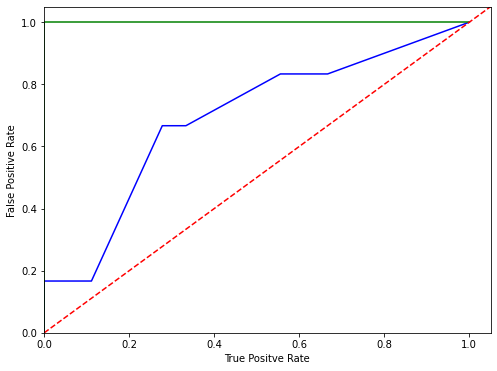

In [127]:
# Calculate metrics for evaluation
# NOTE: this set of instructions can be encapsulated in a FUNCTIOn because it is called multiple times
# HOWEVER, this was not done here

RF_best_model.fit(X_train, y_train)

RF_train_pred = RF_best_model.predict(X_train)
RF_test_pred = RF_best_model.predict(X_test)
RF_train_pred_proba = RF_best_model.predict_proba(X_train)
RF_test_pred_proba = RF_best_model.predict_proba(X_test)

print("Classification report for Randome Forest Classifier \n", metrics.classification_report(y_test, RF_test_pred))

# Calculate classification metrics
RF_train_accuracy = metrics.accuracy_score(y_train, RF_train_pred)
RF_test_accuracy = metrics.accuracy_score(y_test, RF_test_pred)
RF_train_auc = metrics.roc_auc_score(y_train, RF_train_pred_proba[:,1])
RF_test_auc = metrics.roc_auc_score(y_test, RF_test_pred_proba[:,1])
RF_train_fp, RF_train_tp, _ = metrics.roc_curve(y_train, RF_train_pred_proba[:,1])
RF_test_fp, RF_test_tp, _ = metrics.roc_curve(y_test, RF_test_pred_proba[:,1])
RF_train_roc_auc = metrics.auc(RF_train_fp, RF_train_tp)
RF_test_roc_auc = metrics.auc(RF_test_fp, RF_test_tp)
RF_train_precision, RF_train_recall, RF_train_f1_score, _ = precision_recall_fscore_support(
    y_train, RF_train_pred, average='weighted')
RF_test_precision, RF_test_recall, RF_test_f1_score, _ = precision_recall_fscore_support(
    y_test, RF_test_pred, average='weighted')

print("Accuracy score: ", RF_train_accuracy, "(Train), ", RF_test_accuracy, "(Test)")
print("Area Under the Curve (AUC):", RF_train_auc, "(Train)", RF_test_auc, "(Test)")
print("Precision: ", RF_train_precision, "(Train), ", RF_test_precision, "(Test)")
print("Recall: ", RF_train_recall, "(Train), ", RF_test_recall, "(Test)")
print("f1-score: ", RF_train_f1_score, "(Train), ", RF_test_f1_score, "(Test)")

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(RF_test_fp, RF_test_tp, 'b', label='AUC (test) = %0.2f'%RF_test_roc_auc)
plt.plot(RF_train_fp, RF_train_tp, 'g', label='AUC (train) = %0.2f'%RF_train_roc_auc)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.show()

#### KNeighbours Regressor Pipeline

In [128]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('classifier', KNeighborsClassifier())])

In [129]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
N_NEIGHBORS = [5, 10, 20, 30]

param_grid = [
    #{
    #    'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classifier__n_neighbors': N_NEIGHBORS
    #},
    #{
    #    'reduce_dim': [RFE(SVC(kernel='linear', gamma='auto')), RFE(RandomForestClassifier())],
    #    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    #    'classifier__n_neighbors': N_NEIGHBORS
    #},
    {
        'reduce_dim': [RFE(XGBClassifier(booster='gbtree', verbosity=0, silent=True))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__n_neighbors': N_NEIGHBORS
    }
    #,
    #{
    #    'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classifier__n_neighbors': N_NEIGHBORS
    #}
]

In [130]:
# Run the tests
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
KN_best_params = search.best_params_
KN_best_model = search.best_estimator_
KN_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-14 13:56:35.753470
Best CV score = 0.772:
Best parameters:  {'classifier__n_neighbors': 5, 'reduce_dim': RFE(estimator=XGBClassifier(base_score=None, booster='gbtree',
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, gamma=None, gpu_id=None,
                            importance_type='gain',
                            interaction_constraints=None, learning_rate=None,
                            max_delta_step=None, max_depth=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, silent=True, subsample=None,
                            tree_method=None, validate_parameters=None,
                     

Classification report for Randome Forest Classifier 
               precision    recall  f1-score   support

         0.0       0.89      0.94      0.92        18
         1.0       0.80      0.67      0.73         6

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24

Accuracy score:  0.84375 (Train),  0.875 (Test)
Area Under the Curve (AUC): 0.918956043956044 (Train) 0.8981481481481481 (Test)
Precision:  0.8506497683993824 (Train),  0.8710526315789474 (Test)
Recall:  0.84375 (Train),  0.875 (Test)
f1-score:  0.8463005972130061 (Train),  0.871007371007371 (Test)


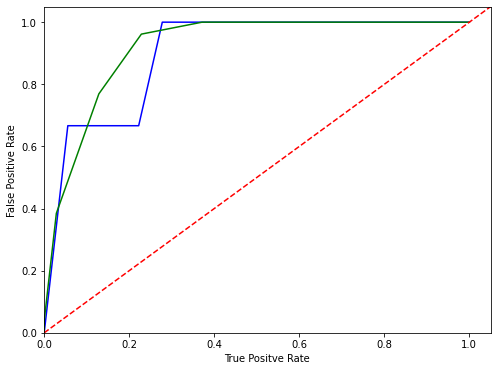

In [131]:
# Calculate metrics for evaluation
KN_best_model.fit(X_train, y_train)

KN_train_pred = KN_best_model.predict(X_train)
KN_test_pred = KN_best_model.predict(X_test)
KN_train_pred_proba = KN_best_model.predict_proba(X_train)
KN_test_pred_proba = KN_best_model.predict_proba(X_test)

print("Classification report for Randome Forest Classifier \n", metrics.classification_report(y_test, KN_test_pred))

# Calculate classification metrics
KN_train_accuracy = metrics.accuracy_score(y_train, KN_train_pred)
KN_test_accuracy = metrics.accuracy_score(y_test, KN_test_pred)
KN_train_auc = metrics.roc_auc_score(y_train, KN_train_pred_proba[:,1])
KN_test_auc = metrics.roc_auc_score(y_test, KN_test_pred_proba[:,1])
KN_train_fp, KN_train_tp, _ = metrics.roc_curve(y_train, KN_train_pred_proba[:,1])
KN_test_fp, KN_test_tp, _ = metrics.roc_curve(y_test, KN_test_pred_proba[:,1])
KN_train_roc_auc = metrics.auc(KN_train_fp, KN_train_tp)
KN_test_roc_auc = metrics.auc(KN_test_fp, KN_test_tp)
KN_train_precision, KN_train_recall, KN_train_f1_score, _ = precision_recall_fscore_support(
    y_train, KN_train_pred, average='weighted')
KN_test_precision, KN_test_recall, KN_test_f1_score, _ = precision_recall_fscore_support(
    y_test, KN_test_pred, average='weighted')

print("Accuracy score: ", KN_train_accuracy, "(Train), ", KN_test_accuracy, "(Test)")
print("Area Under the Curve (AUC):", KN_train_auc, "(Train)", KN_test_auc, "(Test)")
print("Precision: ", KN_train_precision, "(Train), ", KN_test_precision, "(Test)")
print("Recall: ", KN_train_recall, "(Train), ", KN_test_recall, "(Test)")
print("f1-score: ", KN_train_f1_score, "(Train), ", KN_test_f1_score, "(Test)")

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(KN_test_fp, KN_test_tp, 'b', label='AUC (test) = %0.2f'%KN_test_roc_auc)
plt.plot(KN_train_fp, KN_train_tp, 'g', label='AUC (train) = %0.2f'%KN_train_roc_auc)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.show()

#### Support Vector Machine (SVM) Regression Pipeline

In [137]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('classifier', SVC(max_iter=5000, probability=True))])

In [138]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
C_OPTIONS = [0, 10, 20, 50]
GAMMA_OPTIONS = [1, 0.5, 0.1, 0.01, 0.001]
KERNEL_OPTIONS = ['rbf'
                  #, 'linear'
                 ]

param_grid = [
    #{
    #    'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classifier__C': C_OPTIONS,
    #    'classifier__gamma': GAMMA_OPTIONS,
    #    'classifier__kernel': KERNEL_OPTIONS
    #},
    #{
    #    'reduce_dim': [RFE(SVC(kernel='linear', gamma='auto')), RFE(RandomForestClassifier())],
    #    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    #    'classifier__C': C_OPTIONS,
    #    'classifier__gamma': GAMMA_OPTIONS,
    #    'classifier__kernel': KERNEL_OPTIONS
    #},
    {
        'reduce_dim': [RFE(XGBClassifier(booster='gbtree', verbosity=0, silent=True))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__C': C_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS,
        'classifier__kernel': KERNEL_OPTIONS
    }
    #,
    #{
    #    'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classifier__C': C_OPTIONS,
    #    'classifier__gamma': GAMMA_OPTIONS,
    #    'classifier__kernel': KERNEL_OPTIONS
    #}
]

In [139]:
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
SVC_best_params = search.best_params_
SVC_best_model = search.best_estimator_
SVC_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-14 14:18:12.137462
Best CV score = 0.772:
Best parameters:  {'classifier__C': 50, 'classifier__gamma': 0.5, 'classifier__kernel': 'rbf', 'reduce_dim': RFE(estimator=XGBClassifier(base_score=None, booster='gbtree',
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, gamma=None, gpu_id=None,
                            importance_type='gain',
                            interaction_constraints=None, learning_rate=None,
                            max_delta_step=None, max_depth=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, silent=True, subsample=None,
                            tree_method=None, v

Classification report for Randome Forest Classifier 
               precision    recall  f1-score   support

         0.0       0.79      0.83      0.81        18
         1.0       0.40      0.33      0.36         6

    accuracy                           0.71        24
   macro avg       0.59      0.58      0.59        24
weighted avg       0.69      0.71      0.70        24

Accuracy score:  0.9791666666666666 (Train),  0.7083333333333334 (Test)
Area Under the Curve (AUC): 0.9901098901098901 (Train) 0.5740740740740741 (Test)
Precision:  0.9791666666666666 (Train),  0.6921052631578948 (Test)
Recall:  0.9791666666666666 (Train),  0.7083333333333334 (Test)
f1-score:  0.9791666666666666 (Train),  0.699017199017199 (Test)


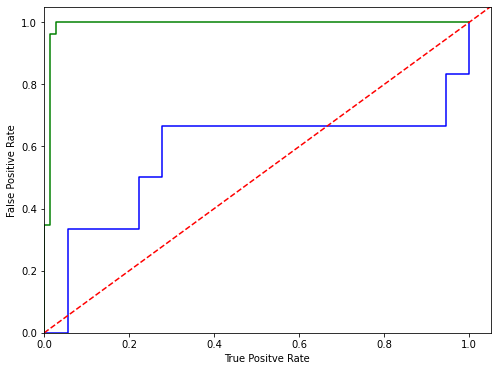

In [140]:
# Calculate metrics for evaluation
SVC_best_model.fit(X_train, y_train)

SVC_train_pred = SVC_best_model.predict(X_train)
SVC_test_pred = SVC_best_model.predict(X_test)
SVC_train_pred_proba = SVC_best_model.predict_proba(X_train)
SVC_test_pred_proba = SVC_best_model.predict_proba(X_test)

print("Classification report for Randome Forest Classifier \n", metrics.classification_report(y_test, SVC_test_pred))

# Calculate classification metrics
SVC_train_accuracy = metrics.accuracy_score(y_train, SVC_train_pred)
SVC_test_accuracy = metrics.accuracy_score(y_test, SVC_test_pred)
SVC_train_auc = metrics.roc_auc_score(y_train, SVC_train_pred_proba[:,1])
SVC_test_auc = metrics.roc_auc_score(y_test, SVC_test_pred_proba[:,1])
SVC_train_fp, SVC_train_tp, _ = metrics.roc_curve(y_train, SVC_train_pred_proba[:,1])
SVC_test_fp, SVC_test_tp, _ = metrics.roc_curve(y_test, SVC_test_pred_proba[:,1])
SVC_train_roc_auc = metrics.auc(SVC_train_fp, SVC_train_tp)
SVC_test_roc_auc = metrics.auc(SVC_test_fp, SVC_test_tp)
SVC_train_precision, SVC_train_recall, SVC_train_f1_score, _ = precision_recall_fscore_support(
    y_train, SVC_train_pred, average='weighted')
SVC_test_precision, SVC_test_recall, SVC_test_f1_score, _ = precision_recall_fscore_support(
    y_test, SVC_test_pred, average='weighted')

print("Accuracy score: ", SVC_train_accuracy, "(Train), ", SVC_test_accuracy, "(Test)")
print("Area Under the Curve (AUC):", SVC_train_auc, "(Train)", SVC_test_auc, "(Test)")
print("Precision: ", SVC_train_precision, "(Train), ", SVC_test_precision, "(Test)")
print("Recall: ", SVC_train_recall, "(Train), ", SVC_test_recall, "(Test)")
print("f1-score: ", SVC_train_f1_score, "(Train), ", SVC_test_f1_score, "(Test)")

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(SVC_test_fp, SVC_test_tp, 'b', label='AUC (test) = %0.2f'%SVC_test_roc_auc)
plt.plot(SVC_train_fp, SVC_train_tp, 'g', label='AUC (train) = %0.2f'%SVC_train_roc_auc)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.show()

#### XGBoost Regressor Pipeline

In [141]:
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('classifier', XGBClassifier(tree_method='auto', booster='gbtree'))])

In [142]:
N_FEATURES_OPTIONS = [5, 8, 10, 15]
N_ESTIMATORS_OPTIONS = [10, 50, 100]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
GAMMA_OPTIONS = [0.01, 0.1, 1, 5, 10]


param_grid = [
    #{
    #    'reduce_dim': [PCA(), KernelPCA(kernel='rbf')],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
    #    'classifier__max_depth': MAX_DEPTH_OPTIONS,
    #    'classifier__gamma': GAMMA_OPTIONS
    #},
    #{
    #    'reduce_dim': [RFE(SVC(kernel='linear', gamma='auto')), RFE(RandomForestClassifier())],
    #    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
    #    'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
    #    'classifier__max_depth': MAX_DEPTH_OPTIONS,
    #    'classifier__gamma': GAMMA_OPTIONS
    #},
    {
        'reduce_dim': [RFE(XGBClassifier(booster='gbtree', verbosity=0, silent=True))],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS
    }
    #,
    #{
    #    'reduce_dim': [LocallyLinearEmbedding(max_iter = 300)],
    #    'reduce_dim__n_components': N_FEATURES_OPTIONS,
    #    'regression__n_estimators': N_ESTIMATORS_OPTIONS,
    #    'regression__max_depth': MAX_DEPTH_OPTIONS,
    #    'regression__gamma': GAMMA_OPTIONS
    #}
]

In [143]:
print("Start processing .....", datetime.datetime.now())
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

print("End processing .....", datetime.datetime.now())

# store the best params and best model for later use
XGB_best_params = search.best_params_
XGB_best_model = search.best_estimator_
XGB_features = search.best_estimator_.named_steps["reduce_dim"].support_

Start processing ..... 2022-08-14 14:31:51.803853
Best CV score = 0.834:
Best parameters:  {'classifier__gamma': 1, 'classifier__max_depth': 4, 'classifier__n_estimators': 10, 'reduce_dim': RFE(estimator=XGBClassifier(base_score=None, booster='gbtree',
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, gamma=None, gpu_id=None,
                            importance_type='gain',
                            interaction_constraints=None, learning_rate=None,
                            max_delta_step=None, max_depth=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, silent=True, subsample=None,
                            tree_method

Classification report for Randome Forest Classifier 
               precision    recall  f1-score   support

         0.0       0.82      0.78      0.80        18
         1.0       0.43      0.50      0.46         6

    accuracy                           0.71        24
   macro avg       0.63      0.64      0.63        24
weighted avg       0.72      0.71      0.72        24

Accuracy score:  1.0 (Train),  0.7083333333333334 (Test)
Area Under the Curve (AUC): 1.0 (Train) 0.8240740740740741 (Test)
Precision:  1.0 (Train),  0.7247899159663865 (Test)
Recall:  1.0 (Train),  0.7083333333333334 (Test)
f1-score:  1.0 (Train),  0.7153846153846154 (Test)


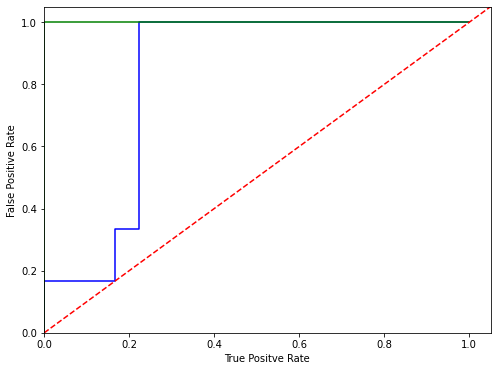

In [144]:
# Calculate metrics for evaluation
XGB_best_model.fit(X_train, y_train)

XGB_train_pred = XGB_best_model.predict(X_train)
XGB_test_pred = XGB_best_model.predict(X_test)
XGB_train_pred_proba = XGB_best_model.predict_proba(X_train)
XGB_test_pred_proba = XGB_best_model.predict_proba(X_test)

print("Classification report for Randome Forest Classifier \n", metrics.classification_report(y_test, XGB_test_pred))

# Calculate classification metrics
XGB_train_accuracy = metrics.accuracy_score(y_train, XGB_train_pred)
XGB_test_accuracy = metrics.accuracy_score(y_test, XGB_test_pred)
XGB_train_auc = metrics.roc_auc_score(y_train, XGB_train_pred_proba[:,1])
XGB_test_auc = metrics.roc_auc_score(y_test, XGB_test_pred_proba[:,1])
XGB_train_fp, XGB_train_tp, _ = metrics.roc_curve(y_train, XGB_train_pred_proba[:,1])
XGB_test_fp, XGB_test_tp, _ = metrics.roc_curve(y_test, XGB_test_pred_proba[:,1])
XGB_train_roc_auc = metrics.auc(XGB_train_fp, XGB_train_tp)
XGB_test_roc_auc = metrics.auc(XGB_test_fp, XGB_test_tp)
XGB_train_precision, XGB_train_recall, XGB_train_f1_score, _ = precision_recall_fscore_support(
    y_train, XGB_train_pred, average='weighted')
XGB_test_precision, XGB_test_recall, XGB_test_f1_score, _ = precision_recall_fscore_support(
    y_test, XGB_test_pred, average='weighted')

print("Accuracy score: ", XGB_train_accuracy, "(Train), ", XGB_test_accuracy, "(Test)")
print("Area Under the Curve (AUC):", XGB_train_auc, "(Train)", XGB_test_auc, "(Test)")
print("Precision: ", XGB_train_precision, "(Train), ", XGB_test_precision, "(Test)")
print("Recall: ", XGB_train_recall, "(Train), ", XGB_test_recall, "(Test)")
print("f1-score: ", XGB_train_f1_score, "(Train), ", XGB_test_f1_score, "(Test)")

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(XGB_test_fp, XGB_test_tp, 'b', label='AUC (test) = %0.2f'%XGB_test_roc_auc)
plt.plot(XGB_train_fp, XGB_train_tp, 'g', label='AUC (train) = %0.2f'%XGB_train_roc_auc)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.show()

### 4. Model Performance Comparison on Training Data

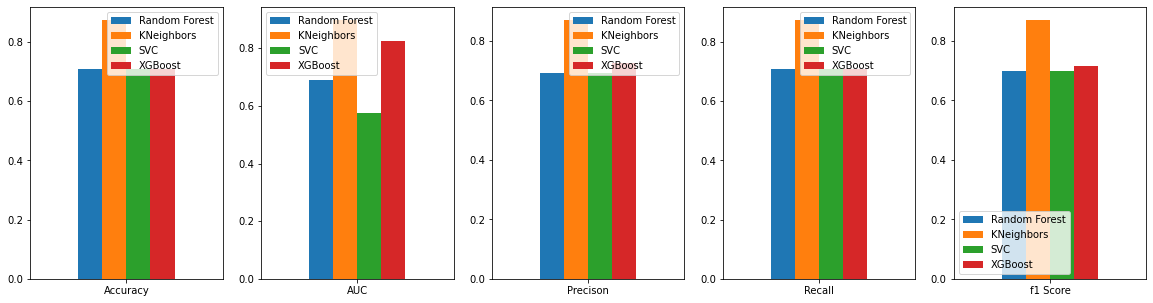

In [146]:
df_accuracy = pd.DataFrame({'Random Forest': RF_test_accuracy, 'KNeighbors': KN_test_accuracy, 'SVC': SVC_test_accuracy, 'XGBoost': XGB_test_accuracy}, index=['Accuracy'])
df_auc = pd.DataFrame({'Random Forest': RF_test_auc, 'KNeighbors': KN_test_auc, 'SVC': SVC_test_auc, 'XGBoost': XGB_test_auc}, index=['AUC'])
df_precision = pd.DataFrame({'Random Forest': RF_test_precision, 'KNeighbors':KN_test_precision, 'SVC': SVC_test_precision, 'XGBoost': XGB_test_precision}, index=['Precison'])
df_recall = pd.DataFrame({'Random Forest': RF_test_recall, 'KNeighbors':KN_test_recall, 'SVC': SVC_test_recall, 'XGBoost': XGB_test_recall}, index=['Recall'])
df_f1 = pd.DataFrame({'Random Forest': RF_test_f1_score, 'KNeighbors':KN_test_f1_score, 'SVC': SVC_test_f1_score, 'XGBoost': XGB_test_f1_score}, index=['f1 Score'])

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

df_accuracy.plot.bar(rot=0, ax=axes[0])
df_auc.plot.bar(rot=0, ax=axes[1])
df_precision.plot.bar(rot=0, ax=axes[2])
df_recall.plot.bar(rot=0, ax=axes[3])
df_f1.plot.bar(rot=0, ax=axes[4])

plt.legend(loc="lower left")
plt.show()

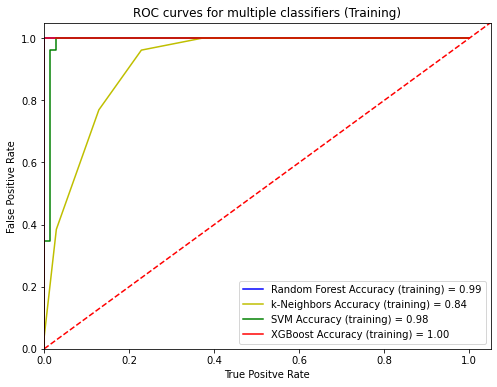

In [157]:
# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(RF_train_fp, RF_train_tp, 'b', label='Random Forest Accuracy (training) = %0.2f'%RF_train_accuracy)
plt.plot(KN_train_fp, KN_train_tp, 'y', label='k-Neighbors Accuracy (training) = %0.2f'%KN_train_accuracy)
plt.plot(SVC_train_fp, SVC_train_tp, 'g', label='SVM Accuracy (training) = %0.2f'%SVC_train_accuracy)
plt.plot(XGB_train_fp, XGB_train_tp, 'r', label='XGBoost Accuracy (training) = %0.2f'%XGB_train_accuracy)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC curves for multiple classifiers (Training)')
plt.legend()
plt.show()

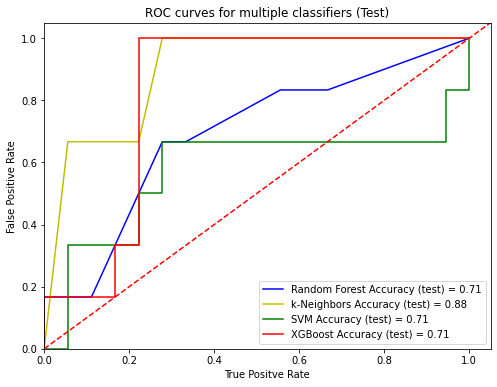

In [158]:
# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(RF_test_fp, RF_test_tp, 'b', label='Random Forest Accuracy (test) = %0.2f'%RF_test_accuracy)
plt.plot(KN_test_fp, KN_test_tp, 'y', label='k-Neighbors Accuracy (test) = %0.2f'%KN_test_accuracy)
plt.plot(SVC_test_fp, SVC_test_tp, 'g', label='SVM Accuracy (test) = %0.2f'%SVC_test_accuracy)
plt.plot(XGB_test_fp, XGB_test_tp, 'r', label='XGBoost Accuracy (test) = %0.2f'%XGB_test_accuracy)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC curves for multiple classifiers (Test)')
plt.legend()
plt.show()